In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import random as rn
import csv
import os
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
# tensorflowの乱数シード固定(再現性の担保)
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(7)
rn.seed(7)

session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

tf.set_random_seed(7)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [3]:
batch_size = 32
n_epochs = 50

# 画像データ取り込み


In [4]:
DATA_FOLDER = '../data/'
datalist = pd.read_csv(os.path.join(DATA_FOLDER, 'frames_data.csv'), names=["img_path", "l_class", 's_class','timestamp'])
datalist.head()

,img_path,l_class,s_class,timestamp
0,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan,5gokan-denkisogokan,2019/10/23 18:50:43
1,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan,5gokan-denkisogokan,2019/10/23 18:50:43
2,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan,5gokan-denkisogokan,2019/10/23 18:50:43
3,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan,5gokan-denkisogokan,2019/10/23 18:50:43
4,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan,5gokan-denkisogokan,2019/10/23 18:50:43


In [5]:
l_classlist = ['4gokan', '5gokan', '5gokan-denkisogokan', '5gokan-mediacenter'
                    '8gokan', 'denkisogokan', 'lab', 'lab-lounge', 'lounge']
s_classlist = ['4gokan_inside', '4gokan_outside', '5gokan-denkisogokan', '5gokan-mediacenter',
'5gokan_1F', '5gokan_2F', '5gokan_3F', '5gokan_ent_east', '5gokan_lounge',
'5gokan_out_east', '5gokan_parking', '5gokan_smoking', '5gokan_stairs_cnt',
'5gokan_stairs_west', '8gokan_1F', '8gokan_ent_north', '8gokan_ent_south',
'denkisogokan_2F', 'denkisogokan_3F', 'denkisogokan_4F', 'denkisogokan_elevator',
'denkisogokan_lounge', 'denkisogokan_stairs', 'lab-lounge', 'lab_bs_cnt',
'lab_corner', 'lab_desk', 'lab_desk_table', 'lab_ent', 'lab_printer',
'lab_table', 'lab_wb_cnt', 'lab_wb_ent', 'lounge']
num_l_class =len(l_classlist)
num_s_class = len(s_classlist)

In [6]:
print(num_s_class)

34


In [7]:
dfl = datalist.drop(['s_class','timestamp'], axis=1)
dfl.head()

,img_path,l_class
0,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan
1,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan
2,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan
3,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan
4,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan


In [8]:
dfl.groupby('l_class').count()

,img_path
l_class,
4gokan,308
5gokan,1328
5gokan-denkisogokan,361
5gokan-mediacenter,127
8gokan,266
denkisogokan,523
lab,1953
lab-lounge,63
lounge,247


In [9]:
dfs = datalist.drop(['l_class', 'timestamp'], axis=1)
dfs.groupby('s_class').count()

,img_path
s_class,
4gokan_inside,60
4gokan_outside,248
5gokan-denkisogokan,361
5gokan-mediacenter,127
5gokan_1F,65
5gokan_2F,96
5gokan_3F,32
5gokan_ent_east,135
5gokan_lounge,361


In [10]:
dfs.img_path.count()

5176

In [11]:
grad_test_img_path =[
    "../data/insta_frames/4gokan/4gokan_inside/4gokan_inside_0_img_000240.png",
    "../data/insta_frames/4gokan/4gokan_outside/4gokan_outside_0_img_000180.png",
    "../data/insta_frames/5gokan-denkisogokan/5gokan-denkisogokan_1_img_000010.png",
    "../data/insta_frames/5gokan-mediacenter/5gokan-mediacenter_0_img_000030.png",
    "../data/insta_frames/5gokan/5gokan_1F/5gokan_1F_0_img_000070.png",
    "../data/insta_frames/5gokan/5gokan_2F/5gokan_2F_2_img_000030.png",
    "../data/insta_frames/5gokan/5gokan_3F/5gokan_3F_0_img_000040.png",
    "../data/insta_frames/5gokan/5gokan_ent_east/5gokan_ent_east_2_img_000000.png",
    "../data/insta_frames/5gokan/5gokan_lounge/5gokan_lounge_2_img_000060.png",
    "../data/insta_frames/5gokan/5gokan_out_east/5gokan_out_east_0_img_000270.png",
    "../data/insta_frames/5gokan/5gokan_parking/5gokan_parking_1_img_000170.png",
    "../data/insta_frames/5gokan/5gokan_smoking/5gokan_smoking_0_img_000270.png",
    "../data/insta_frames/5gokan/5gokan_stairs_cnt/5gokan_stairs_cnt_3_img_000010.png",
    "../data/insta_frames/5gokan/5gokan_stairs_west/5gokan_stairs_west_0_img_000340.png",
    "../data/insta_frames/8gokan/8gokan_1F/8gokan_1F_1_img_000000.png",
    "../data/insta_frames/8gokan/8gokan_ent_north/8gokan_ent_north_0_img_000010.png",
    "../data/insta_frames/8gokan/8gokan_ent_south/8gokan_ent_south_1_img_000070.png",
    "../data/insta_frames/denkisogokan/denkisogokan_2F/denkisogokan_2F_2_img_000300.png",
    "../data/insta_frames/denkisogokan/denkisogokan_3F/denkisogokan_3F_0_img_000010.png",
    "../data/insta_frames/denkisogokan/denkisogokan_4F/denkisogokan_4F_0_img_000170.png",
    "../data/insta_frames/denkisogokan/denkisogokan_elevator/denkisogokan_elevator_0_img_000220.png",
    "../data/insta_frames/denkisogokan/denkisogokan_lounge/denkisogokan_lounge_1_img_000060.png",
    "../data/insta_frames/denkisogokan/denkisogokan_stairs/denkisogokan_stairs_0_img_000120.png",
    "../data/insta_frames/lab-lounge/lab-lounge_0_img_000170.png",
    "../data/insta_frames/lab/lab_bs_cnt/lab_bs_cnt_0_img_000270.png",
    "../data/insta_frames/lab/lab_corner/lab_corner_0_img_000270.png",
    "../data/insta_frames/lab/lab_desk/lab_desk_8_img_000210.png",
    "../data/insta_frames/lab/lab_desk_table/lab_desk_table_3_img_000150.png",
    "../data/insta_frames/lab/lab_ent/lab_ent_0_img_000020.png",
    "../data/insta_frames/lab/lab_printer/lab_printer_0_img_000030.png",
    "../data/insta_frames/lab/lab_table/lab_table_0_img_000170.png",
    "../data/insta_frames/lab/lab_wb_cnt/lab_wb_cnt_0_img_000120.png",
    "../data/insta_frames/lab/lab_wb_ent/lab_wb_ent_1_img_000160.png",
    "../data/insta_frames/lounge/lounge_1_img_000060.png",
]

In [12]:
grad_lab_img = [
    "../data/insta_frames/lab-lounge/lab-lounge_0_img_000170.png",
    "../data/insta_frames/lab-lounge/lab-lounge_0_img_000220.png",
    "../data/insta_frames/lab-lounge/lab-lounge_1_img_000230.png",
    "../data/insta_frames/lab/lab_bs_cnt/lab_bs_cnt_0_img_000020.png",
    "../data/insta_frames/lab/lab_bs_cnt/lab_bs_cnt_0_img_000270.png",
    "../data/insta_frames/lab/lab_bs_cnt/lab_bs_cnt_0_img_000140.png",
    "../data/insta_frames/lab/lab_corner/lab_corner_0_img_000270.png",
    "../data/insta_frames/lab/lab_corner/lab_corner_1_img_000200.png",
    "../data/insta_frames/lab/lab_corner/lab_corner_1_img_000280.png",
    "../data/insta_frames/lab/lab_desk/lab_desk_0_img_000070.png",
    "../data/insta_frames/lab/lab_desk/lab_desk_1_img_000240.png",
    "../data/insta_frames/lab/lab_desk/lab_desk_8_img_000210.png",
    "../data/insta_frames/lab/lab_desk_table/lab_desk_table_0_img_000170.png",
    "../data/insta_frames/lab/lab_desk_table/lab_desk_table_0_img_000220.png",
    "../data/insta_frames/lab/lab_desk_table/lab_desk_table_3_img_000150.png",
    "../data/insta_frames/lab/lab_ent/lab_ent_0_img_000020.png",
    "../data/insta_frames/lab/lab_printer/lab_printer_0_img_000030.png",
    "../data/insta_frames/lab/lab_printer/lab_printer_0_img_000220.png",
    "../data/insta_frames/lab/lab_printer/lab_printer_0_img_000170.png",
    "../data/insta_frames/lab/lab_table/lab_table_0_img_000170.png",
    "../data/insta_frames/lab/lab_table/lab_table_1_img_000290.png",
    "../data/insta_frames/lab/lab_table/lab_table_4_img_000100.png",
    "../data/insta_frames/lab/lab_wb_cnt/lab_wb_cnt_0_img_000120.png",
    "../data/insta_frames/lab/lab_wb_cnt/lab_wb_cnt_0_img_000120.png",
    "../data/insta_frames/lab/lab_wb_cnt/lab_wb_cnt_0_img_000120.png",
    "../data/insta_frames/lab/lab_wb_ent/lab_wb_ent_1_img_000160.png",
    "../data/insta_frames/lab/lab_wb_ent/lab_wb_ent_1_img_000160.png",
    "../data/insta_frames/lab/lab_wb_ent/lab_wb_ent_1_img_000160.png",
    "../data/insta_frames/lounge/lounge_0_img_000020.png",
    "../data/insta_frames/lounge/lounge_1_img_000060.png",
    "../data/insta_frames/lounge/lounge_1_img_000210.png"
]

# Markdown
from sklearn.preprocessing import LabelEncoder

# Markdown
le = LabelEncoder()
le.fit(dfs.s_class)
dfs["labels"] = le.transform(dfs.s_class)
dfs.groupby('labels')

# Markdown
cor_table = dfs.groupby('labels').s_class.unique()
cor_table = pd.DataFrame(cor_table)
cor_table.head()

# Markdown
cor_table.to_csv('cor_table.csv', index=False)

# Markdown
dfs = dfs.drop(['s_class'], axis=1)

# Markdown
x = []
for i in range(len(dfs.img_path)):
    image = img_to_array(load_img(dfs.img_path[i], target_size=(224,224)))
    x.append(image)

# Markdown
y = dfs.labels
print(y)

# Markdown
#正規化
x = np.array(x, dtype='float32')/255

# Markdown
#np.array形式のデータを保存　x, y
np.save(file='x.npy', arr=x)
np.save(file='y.npy', arr=y)

In [13]:
#x, yをload
x = np.load(file='x.npy')
y = np.load(file='y.npy')

画像データを入力の形で保存しておく

In [14]:
print(x.shape)
print(y.shape)

(5176, 224, 224, 3)
(5176,)


# train test & validation set split

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
x, x_valid, y, y_valid = train_test_split(x,y, random_state=42, test_size=0.2, stratify=y)

# EDA(探索的データ解析)


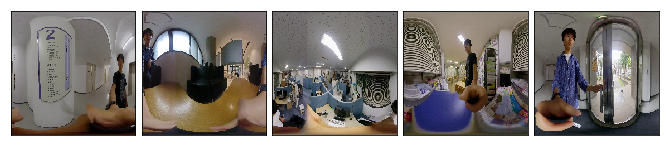

In [17]:
fig = plt.figure(figsize=(9,18))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
    ax.imshow(x[i])

# VGG16(weight="ImageNet", include_top=False)

In [18]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, add, Add, Dropout, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [19]:
from tensorflow.keras.applications.vgg16 import VGG16

In [21]:
vgg_model = VGG16(weights=None, include_top=False, input_shape=(224,224,3))

In [22]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

top(全結合層など)はデフォルトだとImageNetの全クラス数1000での出力になるので，
自作のアーキテクチャを使用する
top以外のモデルの重みは(ImageNetで)固定しない→学習をする

Fine-tuning(Flozen(Not training vgg layers))
training all layers -> acc: 0.1...

inputs = Input(shape=(224,224,3))
x1 = vgg_model(inputs)
x2 = Flatten()(x1)
x3 = Dense(256, activation='relu')(x2)
prediction = Dense(num_s_class, activation='softmax')(x3)
full_model = Model(inputs=inputs, outputs=prediction)
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto')
for layer in vgg_model.layers[:15]:
    layer.trainable = False
full_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [23]:
x1 = vgg_model.output

x2 = Flatten()(x1)
x3 = Dense(256, activation='relu')(x2)
prediction = Dense(num_s_class, activation='softmax')(x3)
full_model = Model(inputs=vgg_model.input, outputs=prediction)

early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto')
for layer in full_model.layers[:15]:
    layer.trainable = False
full_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [24]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

   # 層化抽出法(Stratified sampling)&KFold

In [25]:
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils

Using TensorFlow backend.


In [26]:
skf = StratifiedKFold(n_splits=5, random_state=42)
cvscores = []
#Stratified KFoldはlabel encoding化した整数ベクトルでないともちいることができない
x = np.array(x)
y = np.array(y)
for train_index, test_index in skf.split(x, y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #One-hot化　CNNに入出力できるように整形
    y_train = np_utils.to_categorical(y_train, num_s_class)
    y_test = np_utils.to_categorical(y_test, num_s_class)
    full_model.fit(x_train, y_train, verbose=1, batch_size=batch_size, epochs=n_epochs,
              callbacks=[early_stopping], validation_split=0.2)
    scores = full_model.evaluate(x_test, y_test)
    print("%s: %.2f%%" % (full_model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

Train on 2639 samples, validate on 660 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
2639/2639 [==============================] - 15s 6ms/sample - loss: 2.8582 - acc: 0.2399 - val_loss: 2.3450 - val_acc: 0.3409
Epoch 2/50
2639/2639 [==============================] - 11s 4ms/sample - loss: 1.7370 - acc: 0.5222 - val_loss: 1.2337 - val_acc: 0.6470
Epoch 3/50
2639/2639 [==============================] - 11s 4ms/sample - loss: 0.8789 - acc: 0.7484 - val_loss: 0.7863 - val_acc: 0.7636
Epoch 4/50
2639/2639 [==============================] - 11s 4ms/sample - loss: 0.5560 - acc: 0.8412 - val_loss: 0.4485 - val_acc: 0.8621
Epoch 5/50
2639/2639 [==============================] - 11s 4ms/sample - loss: 0.2748 - acc: 0.9231 - val_loss: 0.3285 - val_acc: 0.9136
Epoch 6/50
2639/2639 [==============================] - 11s 4ms/sample - loss: 0.1750 - acc: 0.9515 - val_loss: 0.1874 - val_acc: 0.9409
Epoch 7/50
2639/2639 [==============================] - 11s 4ms/sample - loss: 0.09

In [27]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

97.82% (+/- 2.40%)


In [28]:
y_pred = full_model.predict(x_valid)

In [29]:
y_valid = np_utils.to_categorical(y_valid)

In [30]:
y_pred = np.array(y_pred)
y_true = np.array(y_valid)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_true, axis=1)

# Confusion Matrix

In [31]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from scipy.sparse.csgraph import connected_components

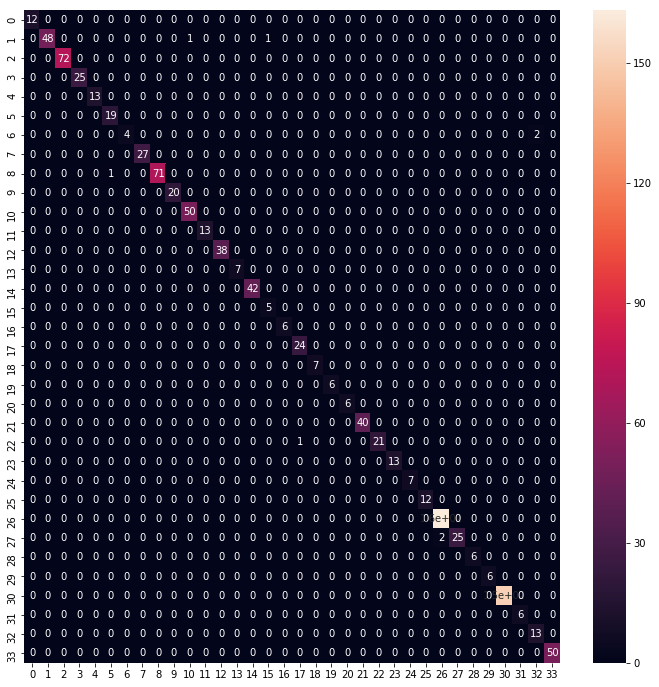

accuracy: 0.9922779922779923


In [32]:
cmx = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(cmx, annot=True)
plt.show()
print('accuracy: {}'.format(accuracy_score
(y_true, y_pred)))

In [33]:
cor_table = pd.read_csv('cor_table.csv')
print(cor_table)

              s_class
0      ['lab-lounge']
1      ['lab_bs_cnt']
2      ['lab_corner']
3        ['lab_desk']
4  ['lab_desk_table']
5         ['lab_ent']
6     ['lab_printer']
7       ['lab_table']
8      ['lab_wb_cnt']
9      ['lab_wb_ent']


# 中間層特徴量の可視化

In [34]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [35]:
x1 = vgg_model.get_layer('block1_pool').output
output1 = GlobalMaxPooling2D()(x1)
block_model1 = Model(inputs=vgg_model.input, outputs=output1)

In [36]:
x2 = vgg_model.get_layer('block2_pool').output
output2 = GlobalMaxPooling2D()(x2)
block_model2 = Model(inputs=vgg_model.input, outputs=output2)

In [37]:
x3 = vgg_model.get_layer('block3_pool').output
output3 = GlobalMaxPooling2D()(x3)
block_model3 = Model(inputs=vgg_model.input, outputs=output3)

In [38]:
x4 = vgg_model.get_layer('block4_pool').output
output4 = GlobalMaxPooling2D()(x4)
block_model4 = Model(inputs=vgg_model.input, outputs=output4)

In [39]:
x5 = vgg_model.get_layer('block5_pool').output
output5 = GlobalMaxPooling2D()(x5)
block_model5 = Model(inputs=vgg_model.input, outputs=output5)

In [40]:
block1 = block_model1.predict(x_train)
block2 = block_model2.predict(x_train)
block3 = block_model3.predict(x_train)
block4 = block_model4.predict(x_train)
block5 = block_model5.predict(x_train)

In [41]:
print(block1.shape)
print(block2.shape)
print(block3.shape)
print(block4.shape)
print(block5.shape)

(3325, 64)
(3325, 128)
(3325, 256)
(3325, 512)
(3325, 512)


# block1の特徴ベクトル

In [42]:
pca = PCA()

In [43]:
cm_name = 'jet'
cmap = plt.get_cmap(cm_name, num_s_class)

In [44]:
# one-hotから整数値ベクトルに変換
y_train_vec = []
for i in range(len(y_train)):
    y_train_vec.append(np.argmax(y_train[i]))

In [45]:
feature1 = pca.fit_transform(block1)
#　主成分分析の例(1層目)
df_feature1 = pd.DataFrame(feature1)
print(df_feature1)

            0         1         2         3         4         5         6   \
0     0.230073  0.047012  0.049147  0.024122 -0.005656 -0.020116 -0.006105   
1     0.009795 -0.021743 -0.059792  0.037031 -0.009967  0.011336  0.012662   
2    -0.008818 -0.061375  0.034009  0.003552 -0.003524 -0.013231  0.004347   
3     0.046985 -0.099731  0.036183 -0.054416  0.024840 -0.036424 -0.031606   
4     0.071811  0.007858 -0.059649  0.003629  0.003986  0.015299 -0.011962   
5     0.059213 -0.036578  0.022412  0.007706 -0.015540 -0.016587 -0.004285   
6    -0.032527 -0.119591 -0.016761  0.023667  0.047664 -0.010433  0.000796   
7    -0.122511 -0.081538  0.029935  0.038950  0.046387  0.065971  0.021987   
8    -0.078588  0.156054  0.028230 -0.038762  0.068219  0.002151  0.016725   
9     0.144089 -0.078782 -0.037602 -0.011811  0.046937  0.086518 -0.023409   
10   -0.205694  0.020683  0.016892 -0.028549  0.006115 -0.033740 -0.056936   
11   -0.082400  0.032283  0.000961 -0.002193  0.039705  0.031082

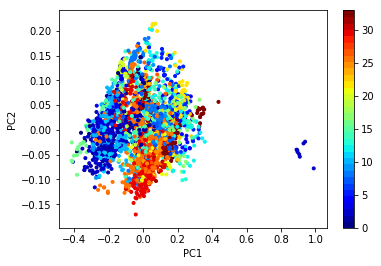

In [46]:
plt.scatter(feature1[:,0],feature1[:,1], marker=".", c=y_train_vec, cmap=cmap)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()

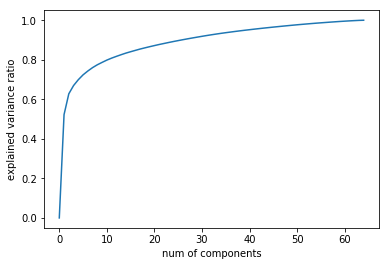

In [47]:
pca.fit(block1)
ev_ratio = pca.explained_variance_ratio_
ev_ratio = np.hstack([0, ev_ratio.cumsum()])
plt.xlabel("num of components")
plt.ylabel("explained variance ratio")
plt.plot(ev_ratio)
plt.show()

# block2の特徴ベクトル 

In [48]:
feature2 = pca.fit_transform(block2)

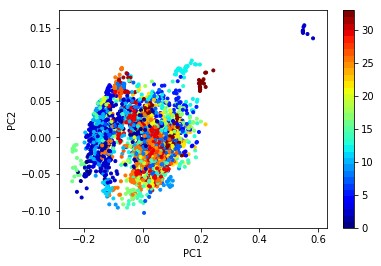

In [49]:
plt.scatter(feature2[:,0],feature2[:,1], marker=".", c=y_train_vec, cmap=cmap)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()

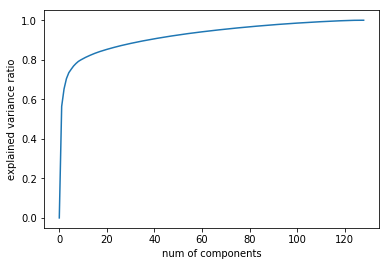

In [50]:
pca.fit(block2)
ev_ratio = pca.explained_variance_ratio_
ev_ratio = np.hstack([0, ev_ratio.cumsum()])
plt.xlabel("num of components")
plt.ylabel("explained variance ratio")
plt.plot(ev_ratio)
plt.show()

# block3の特徴ベクトル 

In [51]:
feature3 = pca.fit_transform(block3)

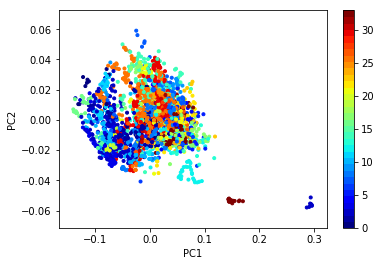

In [52]:
plt.scatter(feature3[:,0],feature3[:,1], marker=".", c=y_train_vec, cmap=cmap)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()

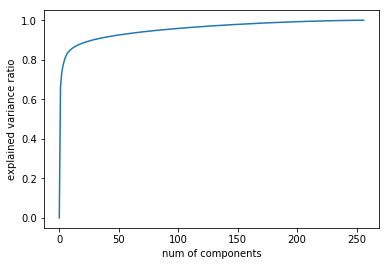

In [53]:
pca.fit(block3)
ev_ratio = pca.explained_variance_ratio_
ev_ratio = np.hstack([0, ev_ratio.cumsum()])
plt.xlabel("num of components")
plt.ylabel("explained variance ratio")
plt.plot(ev_ratio)
plt.show()

# block4の特徴ベクトル

In [54]:
feature4 = pca.fit_transform(block4)

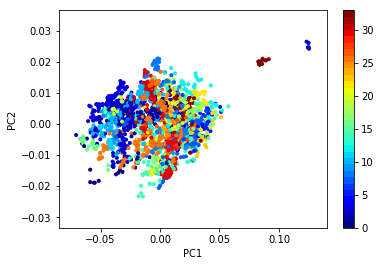

In [55]:
plt.scatter(feature4[:,0],feature4[:,1], marker=".", c=y_train_vec, cmap=cmap)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()

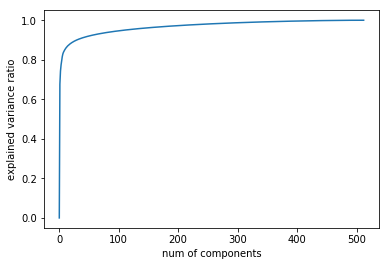

In [56]:
pca.fit(block4)
ev_ratio = pca.explained_variance_ratio_
ev_ratio = np.hstack([0, ev_ratio.cumsum()])
plt.xlabel("num of components")
plt.ylabel("explained variance ratio")
plt.plot(ev_ratio)
plt.show()

# block5の特徴ベクトル 

In [57]:
feature5 = pca.fit_transform(block5)

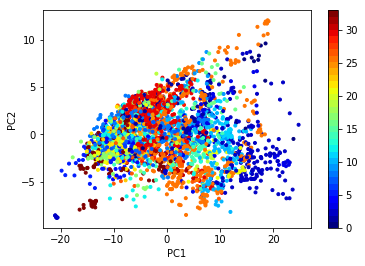

In [58]:
plt.scatter(feature5[:,0],feature5[:,1],marker=".", c=y_train_vec, cmap=cmap)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()

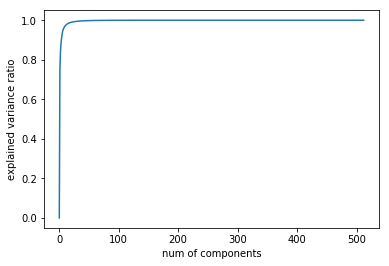

In [59]:
pca.fit(block5)
ev_ratio = pca.explained_variance_ratio_
ev_ratio = np.hstack([0, ev_ratio.cumsum()])
plt.xlabel("num of components")
plt.ylabel("explained variance ratio")
plt.plot(ev_ratio)
plt.show()

In [60]:
from mpl_toolkits.mplot3d import Axes3D

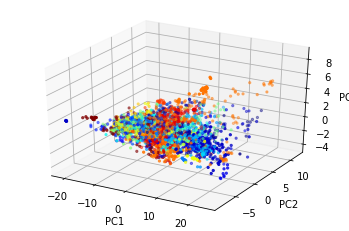

In [61]:
ax = plt.figure().add_subplot(111, projection='3d')
ax.scatter(feature5[:,0],feature5[:,1], feature5[:,3], marker=".", c=y_train_vec, cmap=cmap)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

# grad-cam

In [62]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

In [63]:
true = []
for i in range(num_s_class):
    true.append(i)

In [66]:
pred = []

grad_last_conv = full_model.get_layer("block5_conv3")
model_output = full_model.output[:,0]
grads = K.gradients(model_output, grad_last_conv.output)[0]
pooled_grads = K.mean(grads, axis=(0,1,2))
iterate = K.function([full_model.input], [pooled_grads, grad_last_conv.output[0]])

for n in range(len(grad_lab_img)):
    img_keras = image.load_img(grad_lab_img[n], target_size=(224, 224))
    img_tensor = image.img_to_array(img_keras)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    predicts = full_model.predict(img_tensor)
    s_class_num = np.argmax(predicts)
    pred.append(s_class_num)
    img_tensor /= 255.
    pooled_grads_val, conv_output_val = iterate([img_tensor])
    for i in range(pooled_grads_val.shape[0]):
        conv_output_val[:, :, i] *= pooled_grads_val[i]
    heatmap = np.mean(conv_output_val, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    img = cv2.imread(grad_lab_img[n])
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    save_dir = '../data/gradcam_img/VGG16'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)	# Make a directory
    #保存先ディレクトリ名はその画像のクラス，画像の予測値を画像の名前に書き込む
    cv2.imwrite(save_dir+'/heatmap_wrong_pred_'+s_classlist[s_class_num]+'_'+str(n)+'_'+'.jpg', superimposed_img)
    print('Saved: ', save_dir+'/heatmap_wrong_pred_'+s_classlist[s_class_num]+'.jpg')

Saved:  ../data/gradcam_img/VGG16/heatmap_wrong_pred_lab_table.jpg
Saved:  ../data/gradcam_img/VGG16/heatmap_wrong_pred_lab_desk.jpg
Saved:  ../data/gradcam_img/VGG16/heatmap_wrong_pred_lab_desk.jpg
Saved:  ../data/gradcam_img/VGG16/heatmap_wrong_pred_lab_bs_cnt.jpg
Saved:  ../data/gradcam_img/VGG16/heatmap_wrong_pred_lab_bs_cnt.jpg
Saved:  ../data/gradcam_img/VGG16/heatmap_wrong_pred_lab_bs_cnt.jpg
Saved:  ../data/gradcam_img/VGG16/heatmap_wrong_pred_lab_desk.jpg
Saved:  ../data/gradcam_img/VGG16/heatmap_wrong_pred_lab_desk.jpg
Saved:  ../data/gradcam_img/VGG16/heatmap_wrong_pred_lab_desk.jpg
Saved:  ../data/gradcam_img/VGG16/heatmap_wrong_pred_lab_desk.jpg
Saved:  ../data/gradcam_img/VGG16/heatmap_wrong_pred_lab_desk.jpg
Saved:  ../data/gradcam_img/VGG16/heatmap_wrong_pred_lab_desk.jpg
Saved:  ../data/gradcam_img/VGG16/heatmap_wrong_pred_lab_desk.jpg
Saved:  ../data/gradcam_img/VGG16/heatmap_wrong_pred_lab_desk.jpg
Saved:  ../data/gradcam_img/VGG16/heatmap_wrong_pred_8gokan_1F.jpg
Sa

def grad_cam(input_model, image, cls, layer_name):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam_max = cam.max() 
    if cam_max != 0: 
        cam = cam / cam_max
    return cam


for n in range(len(grad_lab_img)):
    cam = grad_cam(input_model=full_model, image=grad_lab_img[n], cls=-1, layer_name="block5_conv3")
    save_dir = '../data/gradcam_test/VGG16'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)	# Make a directory
    #保存先ディレクトリ名はその画像のクラス，画像の予測値を画像の名前に書き込む
    cv2.imwrite(save_dir+'/heatmap_wrong_pred_'+s_classlist[s_class_num]+'_'+str(n)+'_'+'.jpg', cam)
    print('Saved: ', save_dir+'/heatmap_wrong_pred_'+s_classlist[s_class_num]+'.jpg')

In [67]:
df_grad = pd.DataFrame(grad_lab_img)
df_grad

,0
0,../data/insta_frames/lab-lounge/lab-lounge_0_i...
1,../data/insta_frames/lab-lounge/lab-lounge_0_i...
2,../data/insta_frames/lab-lounge/lab-lounge_1_i...
3,../data/insta_frames/lab/lab_bs_cnt/lab_bs_cnt...
4,../data/insta_frames/lab/lab_bs_cnt/lab_bs_cnt...
5,../data/insta_frames/lab/lab_bs_cnt/lab_bs_cnt...
6,../data/insta_frames/lab/lab_corner/lab_corner...
7,../data/insta_frames/lab/lab_corner/lab_corner...
8,../data/insta_frames/lab/lab_corner/lab_corner...
9,../data/insta_frames/lab/lab_desk/lab_desk_0_i...


In [68]:
cmx = confusion_matrix(true, pred)
plt.figure(figsize=(12,12))
sns.heatmap(cmx, annot=True)
plt.ylabel("truth")
plt.xlabel("prediction")
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [34, 31]

In [ ]:
cor_table = pd.read_csv('cor_table.csv')
print(cor_table)

prediction->edge ==> padding